# Activity: Trying out k-means in the Adobo credit card dataset

1. Given the rfm customer table we produced last week, can you group together customers using kmeans and the recency, frequency monetary value columns, this time, **without using rules to define levels**?

*   Scale the column values
*   Find optimal k using elbow and silhouette method
*  Plot radar plots per cluster
*   Attach resulting cluster labels to each row
*   Compare the new clusters with `rfm_level`. How are they similar/different?



2. Using your new results, can you describe each customer cluster produced using the transactions dataset?
*   Do you still see a clear leveled (1,2,3., 1=lowest, 3=highest) classification, or has it been mixed up?






In [45]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [46]:
# Mount GDrive's folders
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
# This code imports a library "os" that allows file navigation
import os

# This code sets the home directory
# Find your folder and put the path here as a string
os.chdir('/content/drive/MyDrive/Development/DSF/DSFC13 Sprint 1')

## Prepare data

Read csv

In [48]:
# Read the cc_clean csv
df = pd.read_csv("Data/cc_clean.csv")
df.head()

,cc_num,gender,city,city_pop,job,dob,acct_num,acct_num2,trans_num,unix_time,category,amt,trans_datetime
0,6.760000e+11,M,Dasmarinas,659019,Chartered loss adjuster,12/12/1958,7.980000e+11,798000000000,a72eaa86b043eed95b25bbb25b3153a1,1581314011,shopping_net,68.88,2020-02-10 13:53:31
1,3.520000e+15,M,Digos,169393,"Administrator, charities/voluntary organisations",31/08/1970,9.680000e+11,968000000000,060d12f91c13871a13963041736a4702,1590902968,entertainment,50.06,2020-05-31 13:29:28
2,4.140000e+18,M,Calapan,133893,Financial controller,23/07/1953,6.280000e+11,628000000000,18aafb6098ab0923886c0ac83592ef8d,1585461157,food_dining,105.44,2020-03-29 13:52:37
3,4.720000e+15,M,Laoag,111125,Dance movement psychotherapist,11/01/1954,2.570000e+11,257000000000,c20ee88b451f637bc6893b7460e9fee0,1601282159,gas_transport,82.69,2020-09-28 16:35:59
4,3.530000e+15,M,City of Paranaque,665822,"Engineer, water",31/07/1961,5.400000e+11,540000000000,b389cc449c9c298e8c004024449f7a27,1594960430,shopping_net,363.49,2020-07-17 12:33:50


In [49]:
# Read the cc_rfm csv
rfm_df = pd.read_csv("Data/cc_rfm.csv")
rfm_df.head()

,acct_num,recency,recency_score,frequency,frequency_score,total_amt,monetary_score,rfm_score,rfm_level
0,1.240000e+11,24,3,931,3,66457.92,3,9,Top
1,1.690000e+11,141,1,9,1,2814.60,1,3,Low
2,1.700000e+11,24,3,890,3,64448.85,3,9,Top
3,2.010000e+11,25,3,306,2,24489.46,2,7,Top
4,2.038000e+11,111,1,12,1,8803.87,1,3,Low


In [50]:
# Convert to pandas datetimes
df['trans_datetime'] = pd.to_datetime(df['trans_datetime'])
df['dob'] = pd.to_datetime(df['dob'], format='%d/%m/%Y')
df.head()

,cc_num,gender,city,city_pop,job,dob,acct_num,acct_num2,trans_num,unix_time,category,amt,trans_datetime
0,6.760000e+11,M,Dasmarinas,659019,Chartered loss adjuster,1958-12-12,7.980000e+11,798000000000,a72eaa86b043eed95b25bbb25b3153a1,1581314011,shopping_net,68.88,2020-02-10 13:53:31
1,3.520000e+15,M,Digos,169393,"Administrator, charities/voluntary organisations",1970-08-31,9.680000e+11,968000000000,060d12f91c13871a13963041736a4702,1590902968,entertainment,50.06,2020-05-31 13:29:28
2,4.140000e+18,M,Calapan,133893,Financial controller,1953-07-23,6.280000e+11,628000000000,18aafb6098ab0923886c0ac83592ef8d,1585461157,food_dining,105.44,2020-03-29 13:52:37
3,4.720000e+15,M,Laoag,111125,Dance movement psychotherapist,1954-01-11,2.570000e+11,257000000000,c20ee88b451f637bc6893b7460e9fee0,1601282159,gas_transport,82.69,2020-09-28 16:35:59
4,3.530000e+15,M,City of Paranaque,665822,"Engineer, water",1961-07-31,5.400000e+11,540000000000,b389cc449c9c298e8c004024449f7a27,1594960430,shopping_net,363.49,2020-07-17 12:33:50


Add useful columns

In [51]:
# Define the current date
current_date = pd.to_datetime('2022-01-01')

# Calculate the elapsed days from transaction date to current date
df['elapsed_days'] = (current_date - df['trans_datetime']).dt.days

# Calculate age of customer
df['age'] = (current_date - df['dob']).dt.days//365
df

,cc_num,gender,city,city_pop,job,dob,acct_num,acct_num2,trans_num,unix_time,category,amt,trans_datetime,elapsed_days,age
0,6.760000e+11,M,Dasmarinas,659019,Chartered loss adjuster,1958-12-12,7.980000e+11,798000000000,a72eaa86b043eed95b25bbb25b3153a1,1581314011,shopping_net,68.88,2020-02-10 13:53:31,690,63
1,3.520000e+15,M,Digos,169393,"Administrator, charities/voluntary organisations",1970-08-31,9.680000e+11,968000000000,060d12f91c13871a13963041736a4702,1590902968,entertainment,50.06,2020-05-31 13:29:28,579,51
2,4.140000e+18,M,Calapan,133893,Financial controller,1953-07-23,6.280000e+11,628000000000,18aafb6098ab0923886c0ac83592ef8d,1585461157,food_dining,105.44,2020-03-29 13:52:37,642,68
3,4.720000e+15,M,Laoag,111125,Dance movement psychotherapist,1954-01-11,2.570000e+11,257000000000,c20ee88b451f637bc6893b7460e9fee0,1601282159,gas_transport,82.69,2020-09-28 16:35:59,459,68
4,3.530000e+15,M,City of Paranaque,665822,"Engineer, water",1961-07-31,5.400000e+11,540000000000,b389cc449c9c298e8c004024449f7a27,1594960430,shopping_net,363.49,2020-07-17 12:33:50,532,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92427,3.530000e+15,M,Dasmarinas,659019,"Physicist, medical",1965-03-26,2.010000e+11,201000000000,4f77498d91283c4910a636b2e8149dda,1587273415,misc_pos,6.54,2020-04-19 13:16:55,621,56
92428,2.470000e+15,M,San Fernando,306659,"Surveyor, quantity",1935-11-01,5.811000e+11,581000000000,d44f411eabd406a76a60546e723a98fd,1628185569,kids_pets,98.23,2021-08-06 01:46:09,147,86
92429,3.520000e+15,M,Masbate,95389,Wellsite geologist,1967-11-20,5.310000e+11,531000000000,7e767a74cae901c13f1a9d1d37aa63d4,1621481285,grocery_pos,78.79,2021-05-20 11:28:05,225,54
92430,4.620000e+15,M,San Fernando,121812,Personnel officer,1934-11-20,5.550000e+11,555000000000,6ced184c93e66028e8d235ad3060de90,1625341374,personal_care,31.37,2021-07-04 03:42:54,180,87


In [52]:
# get hour of transaction
df['trans_hour'] = df['trans_datetime'].dt.hour

# get weekday, 1=Monday
df['trans_dayofweek'] = df['trans_datetime'].dt.isocalendar().day


# Perform k-means on data in `rfm_df`

In [53]:
# Check rfm_df data set
rfm_df

,acct_num,recency,recency_score,frequency,frequency_score,total_amt,monetary_score,rfm_score,rfm_level
0,1.240000e+11,24,3,931,3,66457.92,3,9,Top
1,1.690000e+11,141,1,9,1,2814.60,1,3,Low
2,1.700000e+11,24,3,890,3,64448.85,3,9,Top
3,2.010000e+11,25,3,306,2,24489.46,2,7,Top
4,2.038000e+11,111,1,12,1,8803.87,1,3,Low
...,...,...,...,...,...,...,...,...,...
83,9.690000e+11,26,3,291,1,20507.08,1,5,Middle
84,9.710000e+11,25,3,907,3,61747.38,3,9,Top
85,9.890000e+11,25,3,301,1,19471.66,1,5,Middle
86,9.940000e+11,25,3,608,2,39818.18,2,7,Top


In [54]:
# Plot the data set
data = rfm_df[['recency','frequency','total_amt']]

array([[<Axes: title={'center': 'recency'}>,
        <Axes: title={'center': 'frequency'}>],
       [<Axes: title={'center': 'total_amt'}>, <Axes: >]], dtype=object)

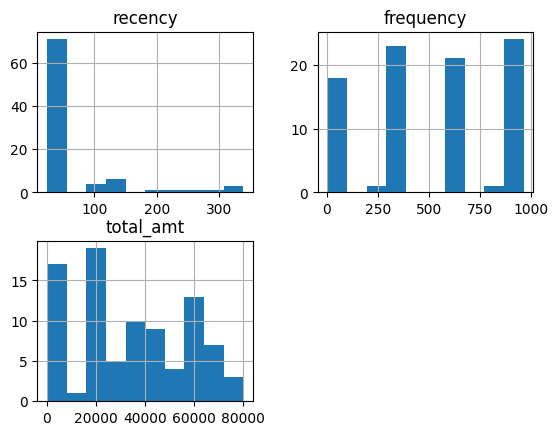

In [55]:
# check histgoram
data.hist()

<Axes: >

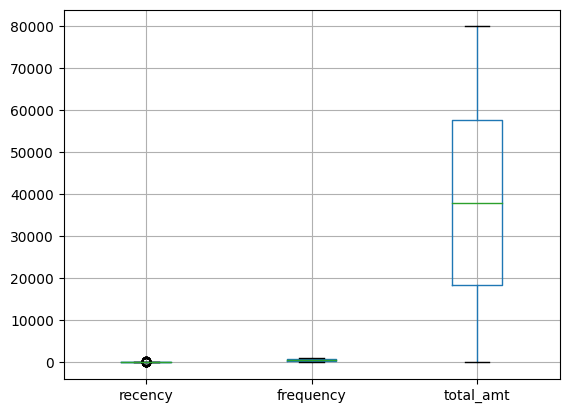

In [56]:
# Check boxplot
data.boxplot()

<Axes: >

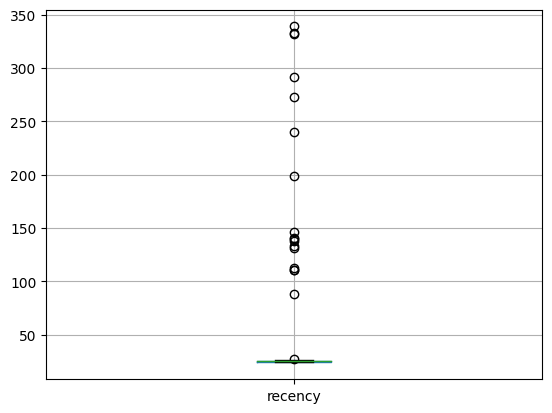

In [57]:
# Check recency boxplot
rfm_df[['recency']].boxplot()

<Axes: >

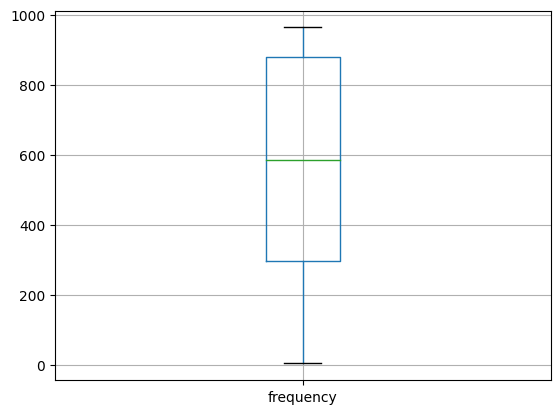

In [58]:
# Check frequency box plot
rfm_df[['frequency']].boxplot()

We standardize our data to ensure all variables are on a similar scale, making it easier to compare them, much like adjusting different units to the same measurement system.

In [59]:
# Call scaler and apply to the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Convert data to pandas
scaled_data = pd.DataFrame(scaled_data, columns=data.columns)

# Show data after scaling
scaled_data

,recency,frequency,total_amt
0,-0.433304,1.311588,1.392169
1,1.102957,-1.441478,-1.440491
2,-0.433304,1.189163,1.302748
3,-0.420174,-0.554644,-0.475778
4,0.709044,-1.432520,-1.173918
...,...,...,...
83,-0.407044,-0.599434,-0.653028
84,-0.420174,1.239925,1.182510
85,-0.420174,-0.569574,-0.699113
86,-0.420174,0.347119,0.206478


We use a technique called clustering to group similar customers together, like organizing books by genre.

In [60]:
# Initialize clustering
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
    )

In [61]:
# Apply clustering to the data
kmeans.fit(scaled_data)

KMeans(init='random', n_clusters=3, n_init=10, random_state=42)

In [62]:
# Display the inertia (the lower, the better)
kmeans.inertia_

46.545056603826026

In [63]:
# Display location of centroids
kmeans.cluster_centers_

array([[-0.42673922,  1.23693868,  1.27397498],
       [ 1.76951955, -1.44305853, -1.33743085],
       [-0.42192472, -0.16952024, -0.23082278]])

These functions help us find the best number of clusters by trying different numbers and evaluating the results, much like taste-testing different recipes to find the best one.

In [64]:
# To test different cluster numbers, let's create a function for clustering for modularity.
def run_kmeans(k, scaled_data):
  kmeans = KMeans(
        init="random",
        n_clusters=k,
        n_init=10,
        max_iter=300,
        random_state=42
        )
  kmeans.fit(scaled_data)
  return kmeans.inertia_,kmeans.labels_

In [65]:
# Create function to run clustering across a range
def optimize_kmeans(cluster_range=None, scaled_data=None):
  # Initialize clustering
  inertias = []
  labels = []
  silhouette_values = []
  for n_clusters in cluster_range:
    inertia, label_vals = run_kmeans(n_clusters, scaled_data)

    # Print inertia
    print(f"n_clusters = {n_clusters}: inertia = {inertia:.2f}")
    inertias.append(inertia)
    labels.append(label_vals)

    # Compute silhouette score
    silhouette = silhouette_score(scaled_data, label_vals)
    silhouette_values.append(silhouette)

  return inertias, labels, silhouette_values

In [66]:
# Test clustering for clusters 2-10
clusters = range(2,11)
inertia_values, labels, silhouette_values = optimize_kmeans(
    cluster_range = clusters,
    scaled_data=scaled_data
)

n_clusters = 2: inertia = 108.69
n_clusters = 3: inertia = 46.55
n_clusters = 4: inertia = 27.30
n_clusters = 5: inertia = 8.04
n_clusters = 6: inertia = 6.72
n_clusters = 7: inertia = 6.06
n_clusters = 8: inertia = 4.16
n_clusters = 9: inertia = 3.62
n_clusters = 10: inertia = 2.92


**The** **inertia** or within-cluster sum of squares (wcss) in clustering is defined as follows: inertia quantifies the compactness (or cohesiveness) of the clusters. The smaller inertia we have within clusters, the more homogeneous (similar) the data points are within the same cluster

**Lower inertia implies better clustering**.

#### Elbow method
Let's identify the optimal number of clusters using the elbow method.

Text(0, 0.5, 'Inertia')

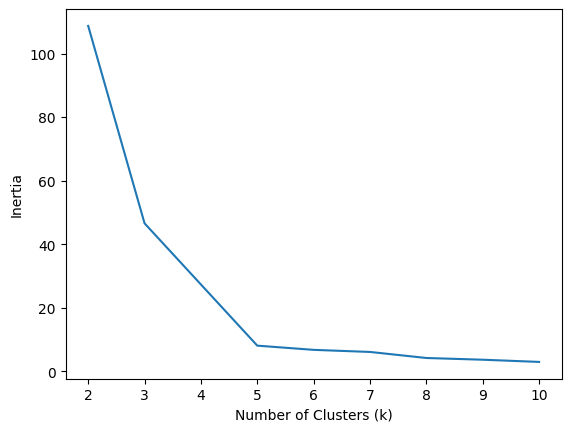

In [67]:
plt.plot(clusters, inertia_values)
plt.xticks(clusters)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")

To find the elbow, you may (1) visually inspect the curve, or (2) compute for the rate of change of slope (aka the 2nd derivative) and use the minimum value to detect where the curve changes the fastest.

In [68]:
# Calculate the first derivative of the inertias
differences = np.diff(inertia_values)

# Calculate the second derivative
second_derivative = np.diff(differences)

# Find the index of the maximum value of the second derivative
# + 1 because index starts at 0 when we did the first derivative
elbow_index = np.argmax(second_derivative) + 1

print(f"The best elbow value (optimal number of clusters) is {clusters[elbow_index]}")

The best elbow value (optimal number of clusters) is 3


#### Silhouette method

We can confirm the optimal cluster detected by the elbow method using the silhouette values score.

Unlike the elbow method, where you're looking for a point where the rate of decrease in inertia slows down, with silhouette score, you're looking for a point where the **silhouette score is maximized**.


Text(0, 0.5, 'Silhouette')

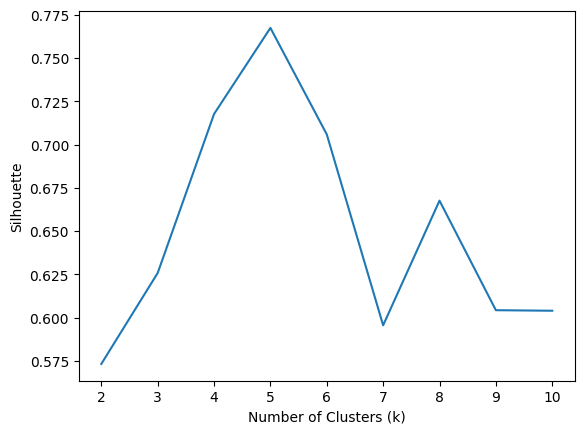

In [69]:
plt.plot(clusters, silhouette_values)
plt.xticks(clusters)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette")

The optimal number of clusters based on the silhouette score is 5


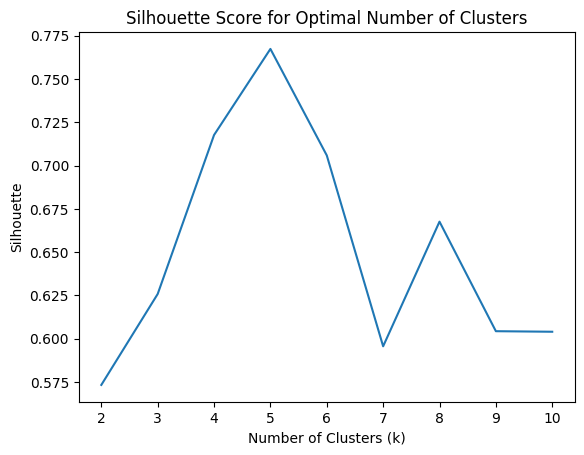

In [70]:
# Assuming silhouette_values is a list or array of silhouette scores for each k
# and clusters is a list or array of the corresponding number of clusters

# Find the index of the maximum silhouette score
optimal_silhouette_index = np.argmax(silhouette_values)

# Get the optimal number of clusters corresponding to the maximum silhouette score
optimal_silhouette_k = clusters[optimal_silhouette_index]

print(f"The optimal number of clusters based on the silhouette score is {optimal_silhouette_k}")

# Plotting the silhouette scores
plt.plot(clusters, silhouette_values)
plt.xticks(clusters)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette")
plt.title("Silhouette Score for Optimal Number of Clusters")
plt.show()


We apply the best clustering model to our data, labeling each customer based on their group, similar to assigning each book its genre.

In [71]:
# Apply optimal k = 3
inertia, labels = run_kmeans(
    k=3,
    scaled_data=scaled_data
)

In [72]:
# Show labels
labels

array([0, 1, 0, 2, 1, 0, 2, 0, 1, 2, 1, 2, 2, 2, 1, 1, 0, 2, 2, 2, 2, 1,
       2, 1, 2, 1, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 0, 0, 1, 1, 0, 1, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 0,
       0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 1, 2, 2, 2, 2, 1, 0, 2, 0, 2, 2, 0],
      dtype=int32)

In [73]:
# Append labels to original data and scaled data
data['labels'] = labels
scaled_data['labels'] = labels

<ipython-input-73-d936c0d1c23f>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [74]:
# Show data
data

,recency,frequency,total_amt,labels
0,24,931,66457.92,0
1,141,9,2814.60,1
2,24,890,64448.85,0
3,25,306,24489.46,2
4,111,12,8803.87,1
...,...,...,...,...
83,26,291,20507.08,2
84,25,907,61747.38,0
85,25,301,19471.66,2
86,25,608,39818.18,2


In [75]:
# Show scaled data
scaled_data

,recency,frequency,total_amt,labels
0,-0.433304,1.311588,1.392169,0
1,1.102957,-1.441478,-1.440491,1
2,-0.433304,1.189163,1.302748,0
3,-0.420174,-0.554644,-0.475778,2
4,0.709044,-1.432520,-1.173918,1
...,...,...,...,...
83,-0.407044,-0.599434,-0.653028,2
84,-0.420174,1.239925,1.182510,0
85,-0.420174,-0.569574,-0.699113,2
86,-0.420174,0.347119,0.206478,2


In [76]:
# Apply groupings in the ORIGINAL dataset
data.groupby('labels').mean()

,recency,frequency,total_amt
labels,,,
0,24.500000,906.000000,63802.383077
1,191.764706,8.470588,5130.120000
2,24.866667,434.977778,29993.049778


In [77]:
# Apply groupings in the SCALED dataset
scaled_data.groupby('labels').mean()

,recency,frequency,total_amt
labels,,,
0,-0.426739,1.236939,1.273975
1,1.769520,-1.443059,-1.337431
2,-0.421925,-0.169520,-0.230823


We analyze the clusters to understand the characteristics of each group, like seeing what type of books each genre contains. We then visualize the clusters to make the insights clear.

In [78]:
# Apply groupings in the dataset then transpose and save
grouped_data = scaled_data.groupby('labels').mean().T

In [79]:
# Show the data
grouped_data

labels,0,1,2
recency,-0.426739,1.769520,-0.421925
frequency,1.236939,-1.443059,-0.169520
total_amt,1.273975,-1.337431,-0.230823


In [80]:
# Show the transformed scaled data
grouped_data

labels,0,1,2
recency,-0.426739,1.769520,-0.421925
frequency,1.236939,-1.443059,-0.169520
total_amt,1.273975,-1.337431,-0.230823


In [81]:
# Plot radar chart per cluster
for i in grouped_data.columns:
  # Filter cluster
  cluster = grouped_data[i]

  # Create radar chart
  fig = px.line_polar(
      cluster,
      r=cluster.values,
      theta=cluster.index,
      line_close=True,
      title=f"Cluster {i}"
      )
  fig.update_traces(fill='toself')

  # Show figure
  fig.show()

In [82]:
# Check length of two datasets before combining
print(data.shape)
print(rfm_df.shape)

(88, 4)
(88, 9)


In [83]:
# Get only labels
data = data['labels']

In [84]:
# Check if both DataFrames have the same number of rows
assert len(rfm_df) == len(data), "The DataFrames do not have the same number of rows"

# Reset index to ensure proper alignment
rfm_df.reset_index(drop=True, inplace=True)
data.reset_index(drop=True, inplace=True)

# Concatenate the DataFrames along the columns (axis=1)
combined_df = pd.concat([rfm_df, data], axis=1)

# Display the combined DataFrame
print(combined_df.head())

       acct_num  recency  recency_score  frequency  frequency_score  \
0  1.240000e+11       24              3        931                3   
1  1.690000e+11      141              1          9                1   
2  1.700000e+11       24              3        890                3   
3  2.010000e+11       25              3        306                2   
4  2.038000e+11      111              1         12                1   

   total_amt  monetary_score  rfm_score rfm_level  labels  
0   66457.92               3          9       Top       0  
1    2814.60               1          3       Low       1  
2   64448.85               3          9       Top       0  
3   24489.46               2          7       Top       2  
4    8803.87               1          3       Low       1  


In [85]:
# check combined df
combined_df.head()

,acct_num,recency,recency_score,frequency,frequency_score,total_amt,monetary_score,rfm_score,rfm_level,labels
0,1.240000e+11,24,3,931,3,66457.92,3,9,Top,0
1,1.690000e+11,141,1,9,1,2814.60,1,3,Low,1
2,1.700000e+11,24,3,890,3,64448.85,3,9,Top,0
3,2.010000e+11,25,3,306,2,24489.46,2,7,Top,2
4,2.038000e+11,111,1,12,1,8803.87,1,3,Low,1


In [86]:
# Analyze the clustering results
cluster_summary = combined_df.groupby('labels').agg({
    'recency': ['mean', 'median'],
    'frequency': ['mean', 'median'],
    'total_amt': ['mean', 'median'],
    'acct_num': 'count'
}).reset_index()

# Rename columns for better readability
cluster_summary.columns = ['cluster', 'recency_mean', 'recency_median', 'frequency_mean', 'frequency_median', 'total_amt_mean', 'total_amt_median', 'count']

# Display the cluster summary
cluster_summary

,cluster,recency_mean,recency_median,frequency_mean,frequency_median,total_amt_mean,total_amt_median,count
0,0,24.500000,24.5,906.000000,920.5,63802.383077,62781.35,26
1,1,191.764706,141.0,8.470588,9.0,5130.120000,5573.74,17
2,2,24.866667,25.0,434.977778,321.0,29993.049778,25566.60,45


Cluster 2:

Recency: High (mean ~191.76, median ~141) Frequency: Low (mean ~9, median ~9) Monetary: Low (mean ~5325.40, median ~5573.74) Count: 17 Interpretation: Customers in this cluster have not made a purchase in a long time, buy infrequently, and spend less. They might be at risk of churning.

Cluster 1:

Recency: Very low (mean ~24.48, median ~24) Frequency: Very high (mean ~1055.59, median ~990) Monetary: Very high (mean ~73569.62, median ~69221.70) Count: 27 Interpretation: These are highly active and valuable customers who purchase frequently and spend a lot. They are your top customers.

Cluster 0:

Recency: Low (mean ~24.77, median ~25) Frequency: High (mean ~467, median ~348) Monetary: Moderate (mean ~32482.28, median ~27812.70) Count: 39 Interpretation: Customers in this cluster are also active but with a moderate level of spending compared to Cluster 1.


Next Steps:

Engage Cluster  1: Develop loyalty programs and special offers to retain these top customers.

Win Back Cluster 0: Create targeted campaigns to re-engage these inactive customers.

Maintain Cluster 2: Provide personalized offers to keep these customers active and potentially increase their spending.